In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_0059561.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_0069932.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_0065476.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_0057072.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_0054359.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_0060775.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_8080515.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_6529148.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_0067377.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_3401800.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_0064789.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_0054878.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_0067394.jpg
/kaggle/input/Skin Cancer Dataset/Acitinic Keratosis/ISIC_0066509.jpg
/kaggle/input/Skin C

In [11]:
import os

In [12]:
!pip install split-folders

In [19]:
import splitfolders

input_folder = r'/kaggle/input/Skin Cancer Dataset'

# Split with a ratio
# To only split into training and validation set, set a tuple to ratio, i.e; 80/20
#Train, val, test
splitfolders.ratio(input_folder, output=r'/kaggle/working/Split', 
                   seed=42, ratio=(.7, .1, .2), 
                   group_prefix=None) # default values

Copying files: 4109 files [00:41, 98.18 files/s] 


In [6]:
#/kaggle/working/Split/train

In [20]:
train_dir = '/kaggle/working/Split/train'
val_dir = '/kaggle/working/Split/val'
test_dir = '/kaggle/working/Split/test'
batch_size = 64

In [21]:
from tensorflow.keras.utils import image_dataset_from_directory # type: ignore

def load_data(data_dir: str):

    ds = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(150,150),
    batch_size=batch_size)

    return ds

In [50]:
train_ds = load_data(train_dir)
val_ds = load_data(val_dir)
test_ds = load_data(test_dir)

Found 2874 files belonging to 9 classes.
Found 409 files belonging to 9 classes.
Found 824 files belonging to 9 classes.


In [69]:
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D,Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet import preprocess_input

In [76]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

#add augmentation

data_augmentation = Sequential()

data_augmentation.add(layers.RandomFlip("horizontal"))
data_augmentation.add(layers.RandomZoom(0.1))
data_augmentation.add(layers.RandomTranslation(0.2, 0.2))
data_augmentation.add(layers.RandomRotation(0.1))

# initialize the model but without the top as we'll adapt it to our problem
inputs = layers.Input(shape=(150, 150, 3))

x = data_augmentation(inputs) # We still have our data augmentation layers
x = preprocess_input(x) # Then a preprocessing layer specifically designed for the VGG16
x = base_model(x) # Then our transfer learning model

x = layers.Flatten()(x) # Followed by our custom dense layers, tailored to our binary task

x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
pred = layers.Dense(9, activation="softmax")(x)

# We use the keras Functional API to create our keras model

model = Model(inputs=inputs , outputs=pred)

# And we freeze the model

base_model.trainable = False

adam = optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()



Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32            │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 150, 150, 3)    │              0 │ input_layer_32[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_12 (GetItem)     │ (None, 150, 150)       │              0 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_13 (GetItem)     │ (None, 150, 150)       │              0 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_14 (GetItem)     │ (None, 150, 150)       │              0 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_4 (Stack)           │ (None, 150, 150, 3)    │              0 │ get_item_12[0][0],     │
│                           │                        │                │ get_item_13[0][0],     │
│                           │                        │                │ get_item_14[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 150, 150, 3)    │              0 │ stack_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 4, 4, 512)      │     14,714,688 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 8192)           │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 512)            │      4,194,816 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 512)            │              0 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 256)            │        131,328 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 256)            │              0 │ dense_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 9)              │          2,313 │ dropout_23[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 19,043,145 (72.64 MB)

 Trainable params: 4,328,457 (16.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [77]:
# def some callbacks
'''LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                        factor=0.1,
                                        patience=3,
                                        verbose=1,
                                        min_lr=0)'''

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss',
                                       patience=10,
                                       verbose=0,
                                       restore_best_weights=True)

# fit the model with training data
history = model.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        callbacks=[EarlyStopper]
        )


Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 354ms/step - accuracy: 0.1927 - loss: 7.0053 - val_accuracy: 0.2616 - val_loss: 1.9495
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 327ms/step - accuracy: 0.2558 - loss: 2.1456 - val_accuracy: 0.3227 - val_loss: 1.9584
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.2840 - loss: 2.0159 - val_accuracy: 0.4083 - val_loss: 1.7091
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step - accuracy: 0.3288 - loss: 1.9915 - val_accuracy: 0.4328 - val_loss: 1.6550
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.3391 - loss: 1.8720 - val_accuracy: 0.4474 - val_loss: 1.6303
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.3799 - loss: 1.7432 - val_accuracy: 0.4523 - val_loss: 1.5260
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 364ms/step - accuracy: 0.3944 - loss: 1.7286 - val_accuracy: 0.4792 - val_loss: 1.5330
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 333ms/step - accuracy: 0.4126 - loss: 1.6701 - val_accu

In [78]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

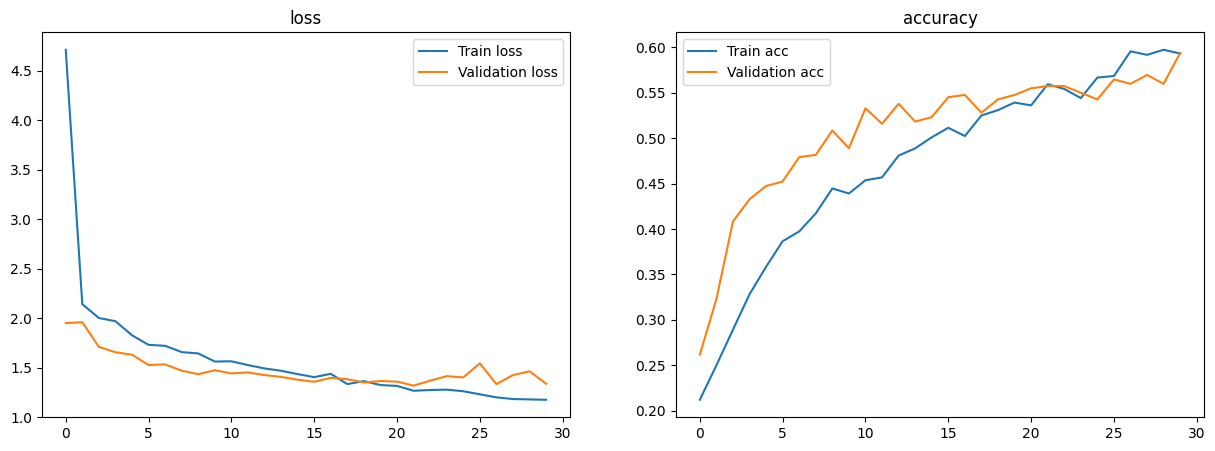

In [79]:
plot_history(history)

In [80]:
history.history

{'accuracy': [0.2118997871875763,
  0.24982602894306183,
  0.28914403915405273,
  0.3281141221523285,
  0.35838553309440613,
  0.38656923174858093,
  0.3973556160926819,
  0.4171885848045349,
  0.44467639923095703,
  0.43910926580429077,
  0.4537230432033539,
  0.45685455203056335,
  0.48086291551589966,
  0.4888657033443451,
  0.5010438561439514,
  0.5114822387695312,
  0.5024356245994568,
  0.5250521898269653,
  0.5309672951698303,
  0.5393180251121521,
  0.5361865162849426,
  0.5594989657402039,
  0.5542797446250916,
  0.5441892743110657,
  0.5668058395385742,
  0.5685455799102783,
  0.5956854820251465,
  0.5918580293655396,
  0.5974251627922058,
  0.5932497978210449],
 'loss': [4.709936618804932,
  2.140503406524658,
  2.0007479190826416,
  1.9685401916503906,
  1.8262906074523926,
  1.7298916578292847,
  1.7200636863708496,
  1.6563575267791748,
  1.6431431770324707,
  1.5610682964324951,
  1.5637391805648804,
  1.5253565311431885,
  1.4915740489959717,
  1.4679313898086548,
  1.4

In [81]:
model.save("augm_model_VGG16.keras")